# 1 - Geração e Análise do Dataset

> Para a geração de dados com outliers, foram gerados 150 pontos, sendo 50 pontos perfeitamente lineares e 100 pontos sendo outliers. Para identificar os outliers, foi usado o zscore
> O gráfico ilustra a detecção de outliers usando Z-score, com base em dados que seguem a relação linear y=2.5x+10. Os dados normais seguem essa tendência e aparecem em verde, enquanto outliers artificiais foram inseridos e identificados em vermelho usando o critério Z>3. Como o Z-score foi calculado apenas com os dados normais, o método se mostrou eficaz em detectar os pontos anômalos, que estão claramente distantes da linha verdadeira. Isso destaca a utilidade do Z-score para identificar desvios extremos quando a distribuição principal é bem comportada.
> O Z-score é uma medida que indica quantos desvios padrão um valor está distante da média dos dados. é calculado pela fórmula: 𝑍 = (x - 𝜇) / 𝜎

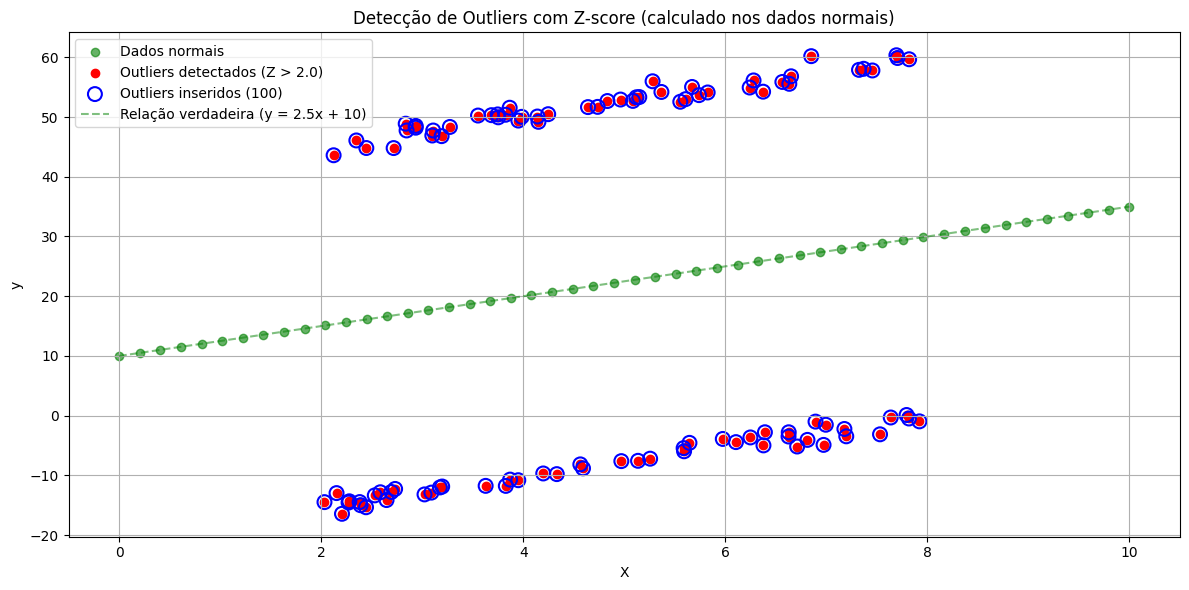

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers.synthetic_data import generate_linear_data


np.random.seed(43)
n_samples    = 50
n_outliers   = 100
offset       = 30
noise_std    = 1.0
limiar       = 2.0

# Geração dos dados com outliers
X, y = generate_linear_data(
    ang_coef=2.5,
    linear_coef=10.0,
    n_samples=n_samples,
    with_outliers=True,
    n_outliers=n_outliers,
    outlier_offset=offset,
    noise_std=noise_std,
)

data = pd.DataFrame({'X': X.ravel(), 'y': y})
data['Outlier_inserido'] = False
data.loc[n_samples:, 'Outlier_inserido'] = True

y_without_outliers = y[:n_samples]
mean_without_outliers = y_without_outliers.mean()
std_without_outliers = y_without_outliers.std()

data['Z_score'] = (data['y'] - mean_without_outliers) / std_without_outliers
data['Outlier_Zscore'] = data['Z_score'].abs() > limiar

plt.figure(figsize=(12, 6))

plt.scatter(data.loc[~data['Outlier_inserido'], 'X'],
            data.loc[~data['Outlier_inserido'], 'y'],
            color='green', alpha=0.6, label='Dados normais')

plt.scatter(data.loc[data['Outlier_Zscore'], 'X'],
            data.loc[data['Outlier_Zscore'], 'y'],
            color='red', label=f'Outliers detectados (Z > {limiar})')

plt.scatter(data.loc[data['Outlier_inserido'], 'X'],
            data.loc[data['Outlier_inserido'], 'y'],
            facecolors='none', edgecolors='blue', s=100,
            linewidths=1.5, label=f'Outliers inseridos ({n_outliers})')

idx_sorted = np.argsort(X[:n_samples].ravel())
X_norm_sorted = X[:n_samples].ravel()[idx_sorted]
y_norm_sorted = y[:n_samples][idx_sorted]

plt.plot(X_norm_sorted, y_norm_sorted, 'g--', alpha=0.5, label='Relação verdadeira (y = 2.5x + 10)')

plt.title("Detecção de Outliers com Z-score (calculado nos dados normais)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2 - Ajuste e Comparação de Modelos

## Fontes:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html

> Neste experimento, foram comparados os algoritmos de regressão LinearRegression, SVR com kernel linear (ε = 0.1, C = 10), RANSAC com configurações padrão e HuberRegressor com ε = 1, utilizando o mesmo conjunto de dados gerado anteriormente. O hiperparâmetro epsilon no HuberRegressor controla o limite a partir do qual os resíduos passam a ser tratados como outliers, influenciando diretamente sua robustez.

> O HuberRegressor obteve o menor erro quadrático médio (MSE = 529.82), indicando melhor desempenho no ajuste, possivelmente por equilibrar bem a influência dos outliers sem descartá-los completamente. Em seguida, o SVR linear apresentou desempenho muito próximo (MSE = 530.35), mostrando-se eficaz na presença de ruído. A regressão linear simples teve erro um pouco maior (MSE = 545.37), evidenciando sua sensibilidade a outliers. Já o RANSAC teve o pior desempenho (MSE = 1140.95), o que sugere que, com suas configurações padrão, não foi eficaz em isolar os dados ruidosos neste cenário. Esses resultados mostram que o HuberRegressor foi o mais robusto ao lidar com os outliers, seguido de perto pelo SVR.

In [68]:
import pandas as pd
from typing import Dict


LINEAR     = 'Linear'
SVR_LINEAR = 'SVR Linear'
RANSAC     = 'RANSAC'
HUBER      = 'Huber'

def show_mse_per_model(models_mses: Dict[str, float]) -> None:
    mse_df = pd.DataFrame([
        {"Model": model, "MSE": mse}
        for model, mse in mses.items()
    ])
    mse_df = mse_df.sort_values(by="MSE").reset_index(drop=True)
    print("----MSE per algorithm----")
    print(mse_df)


----MSE per algorithm----
        Model          MSE
0       Huber   529.821774
1  SVR Linear   530.349524
2      Linear   545.368324
3      RANSAC  1140.946676


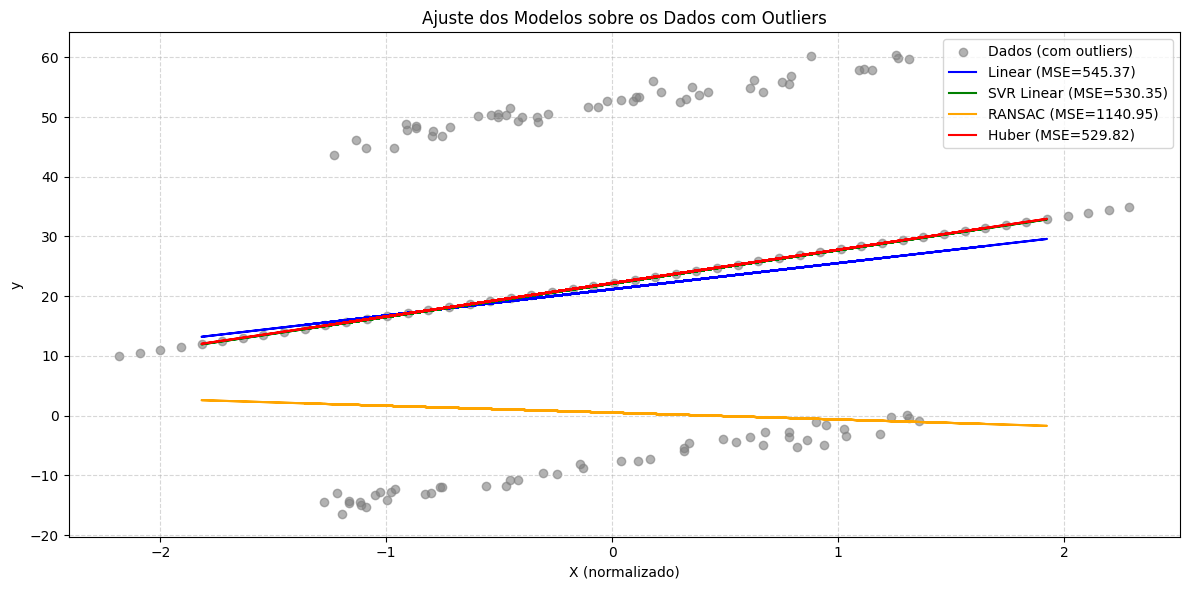

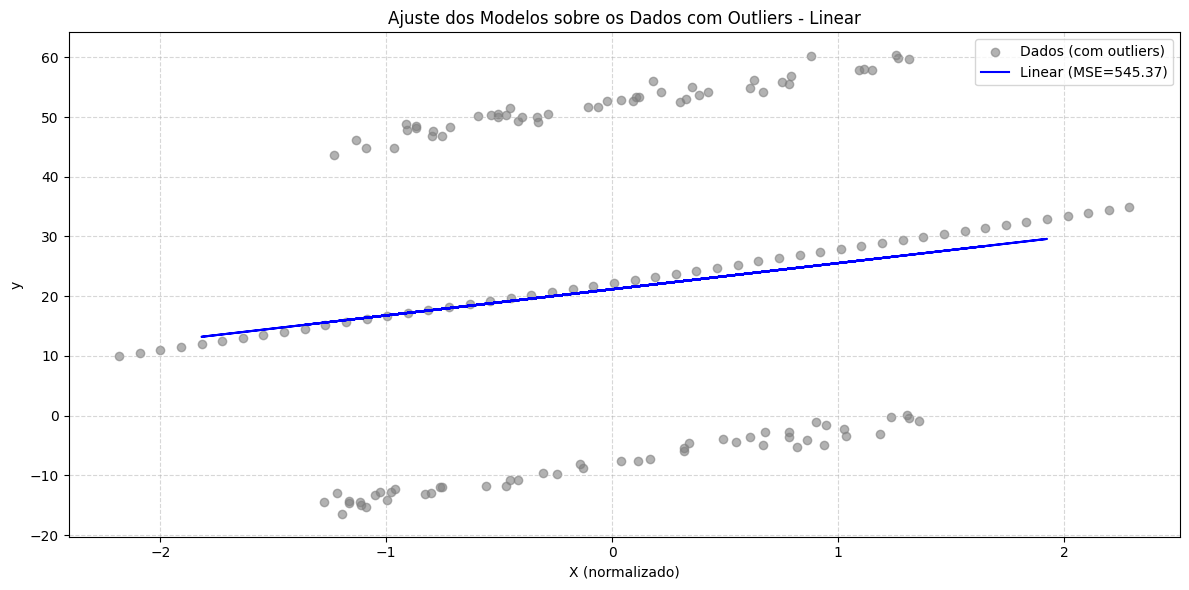

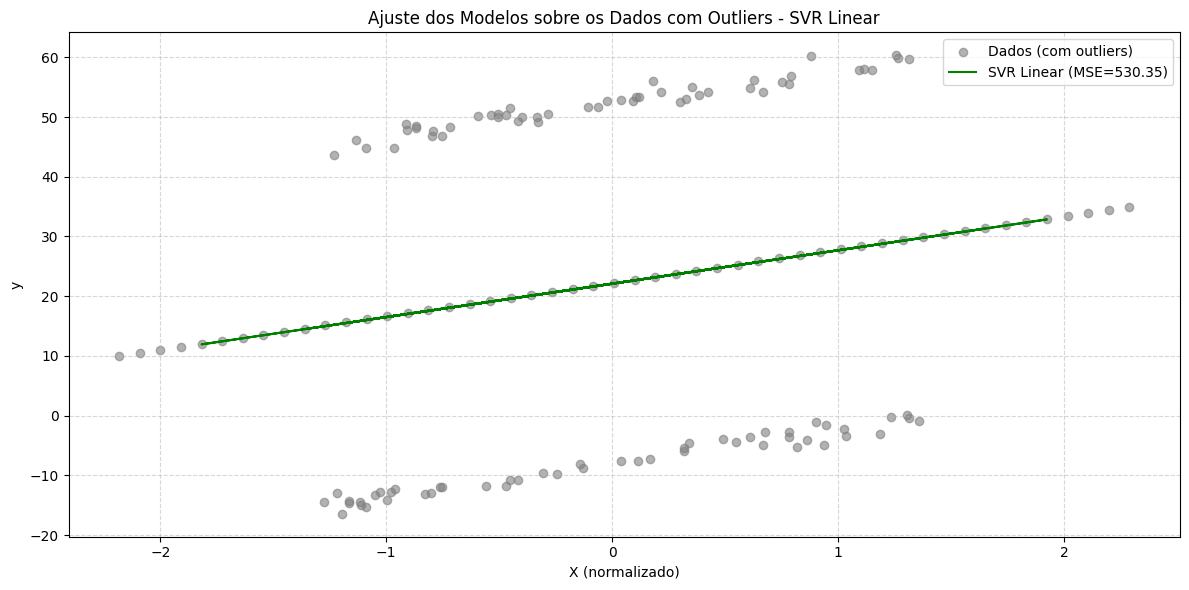

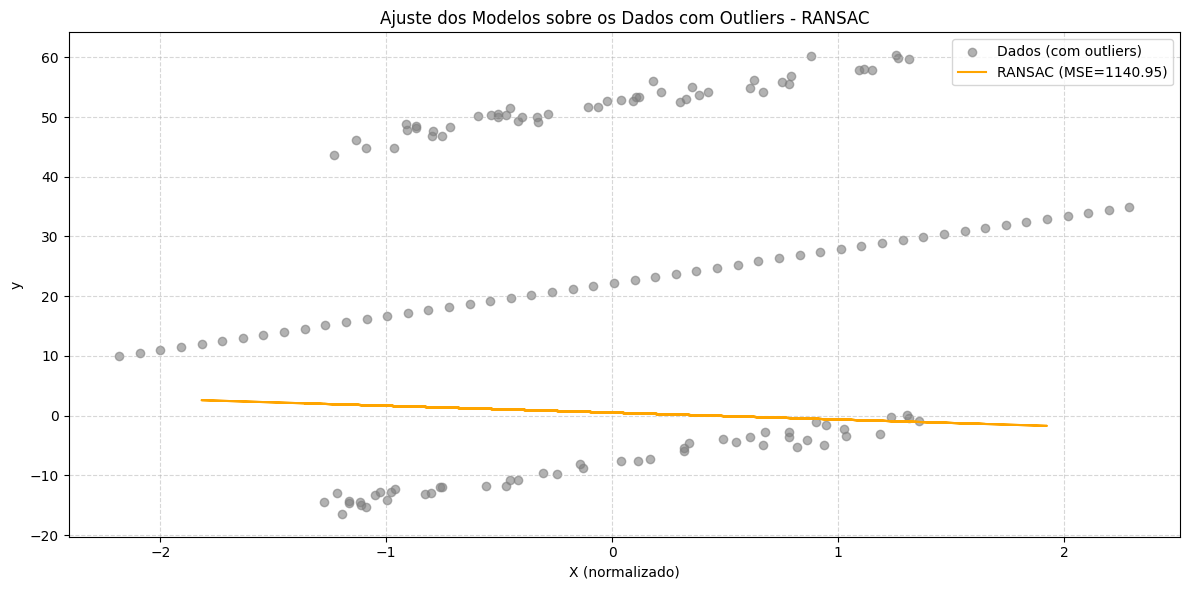

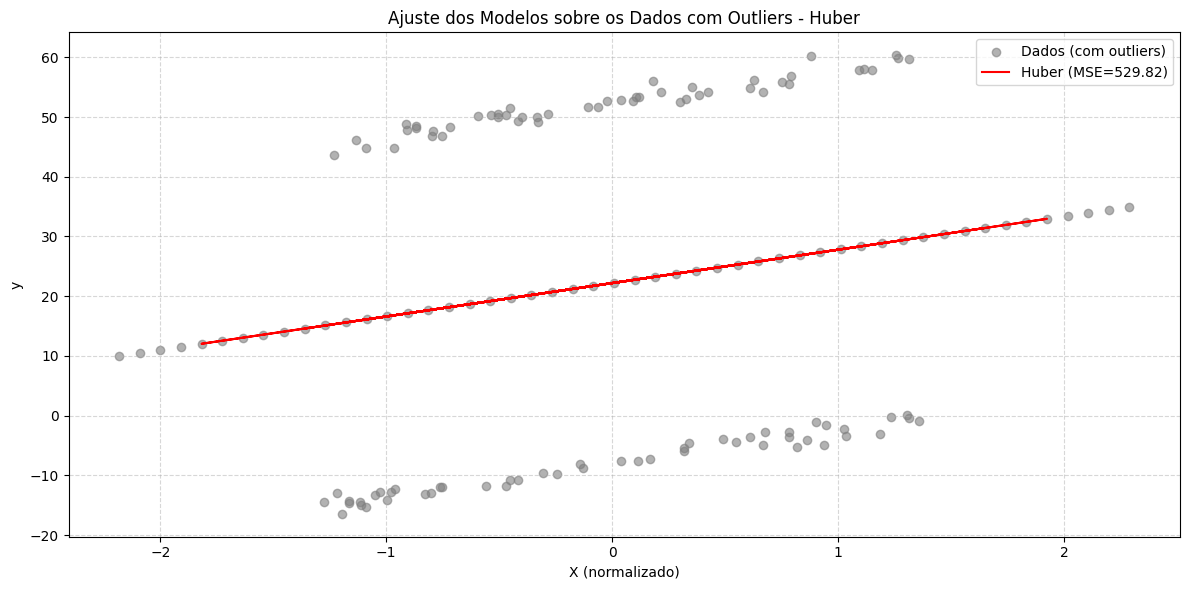

In [69]:
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    LINEAR: LinearRegression(),
    SVR_LINEAR: SVR(kernel='linear', C=10.0, epsilon=0.1),
    RANSAC: RANSACRegressor(),
    HUBER: HuberRegressor(epsilon=1.0)
}

predictions = dict()
mses = dict()

for algorithm, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[algorithm] = y_pred
    mses[algorithm] = mean_squared_error(y_test, y_pred)

show_mse_per_model(mses)

cores = {
    LINEAR: 'blue',
    SVR_LINEAR: 'green',
    RANSAC: 'orange',
    HUBER: 'red'
}


plt.figure(figsize=(12, 6))
plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
for algorithm, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
plt.title("Ajuste dos Modelos sobre os Dados com Outliers")
plt.xlabel("X (normalizado)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


for algorithm, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
    plt.title(f"Ajuste dos Modelos sobre os Dados com Outliers - {algorithm}")
    plt.xlabel("X (normalizado)")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()



# 3 - Experimento: Remoção de Outliers

> Removendo os outliers e mantendo os mesmos hiperparâmetros, pôde-se perceber que todos os modelos tiveram um desempenho satisfatório. Todos apresentaram MSE muito próximo de 0 e graficamente todos formaram uma reta que se encaixa muito bem aos dados.

----MSE per algorithm----
        Model           MSE
0      Linear  6.037415e-29
1      RANSAC  6.037415e-29
2       Huber  1.489352e-23
3  SVR Linear  3.285004e-03


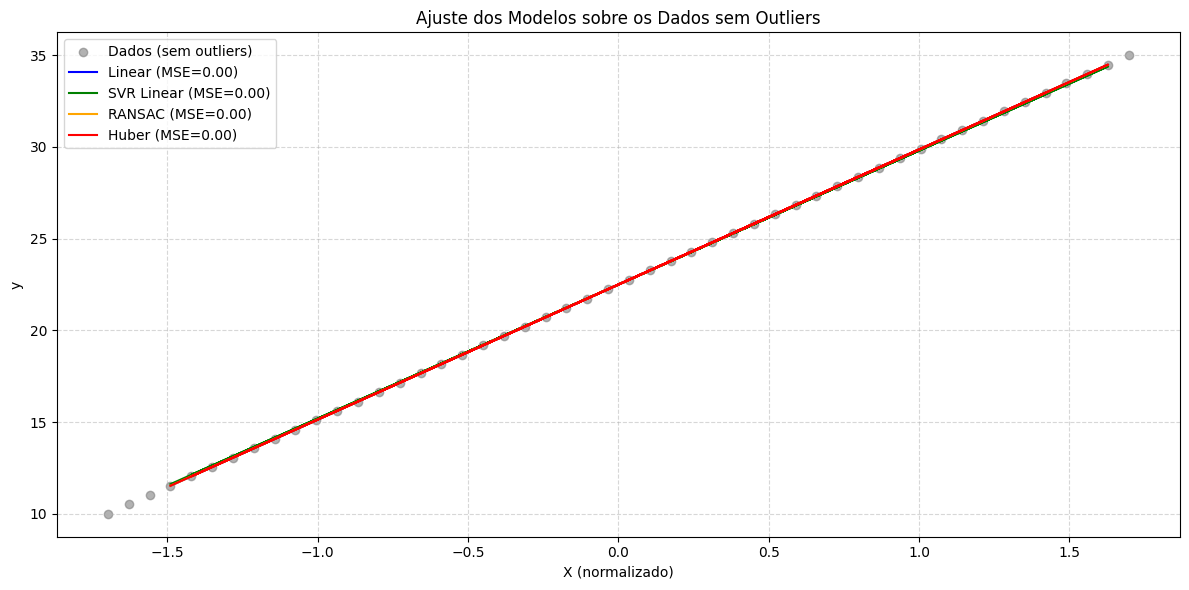

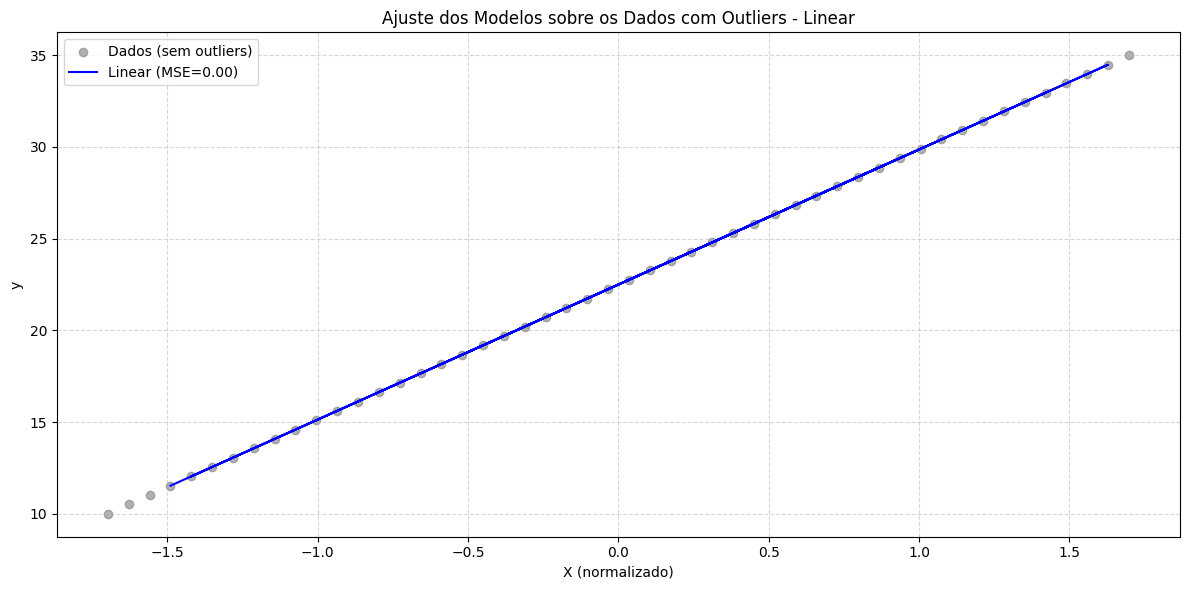

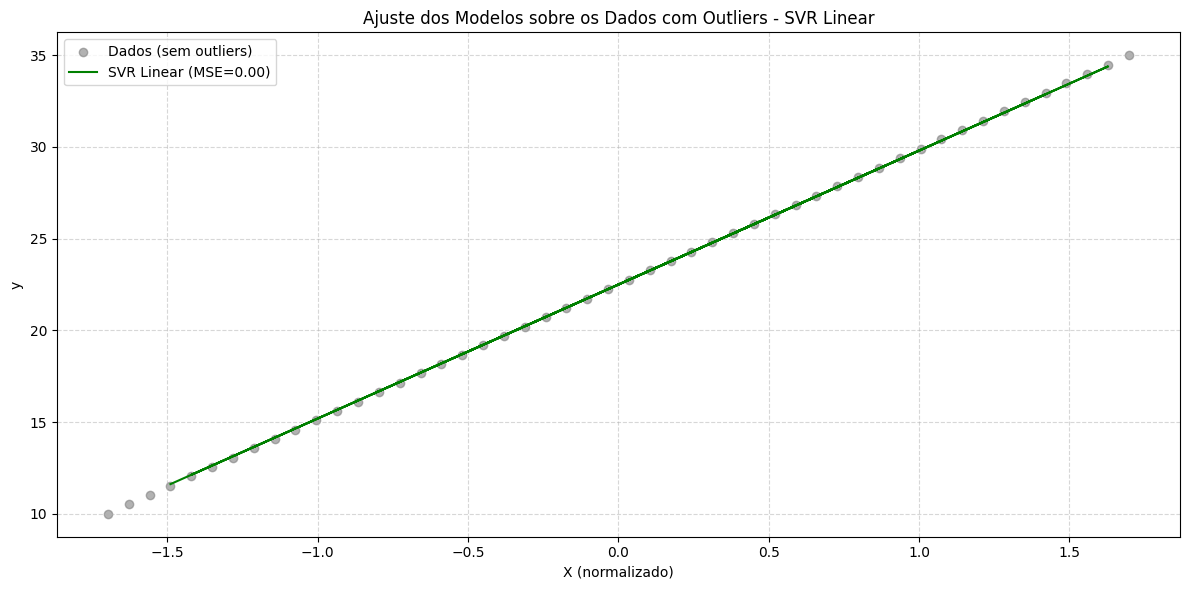

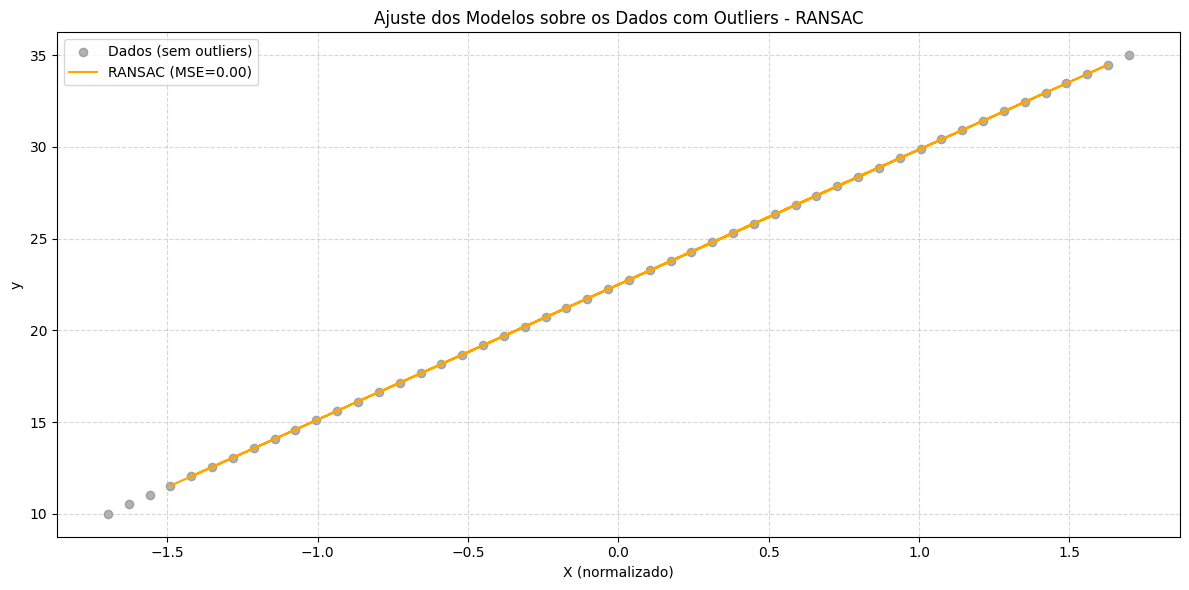

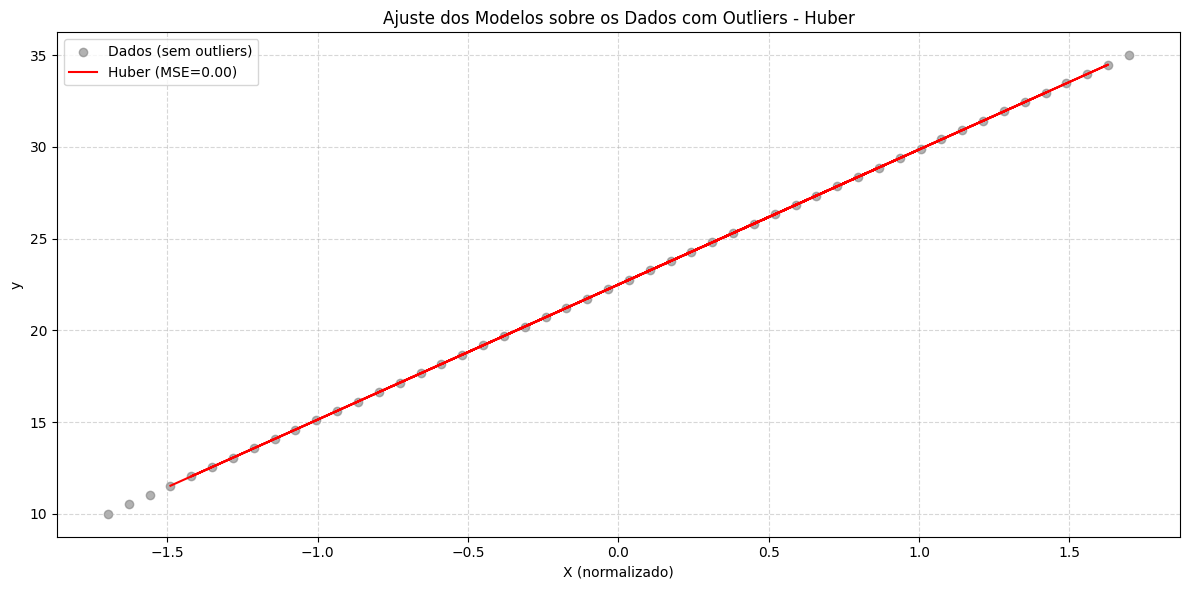

In [70]:
X, y = generate_linear_data(ang_coef=2.5, linear_coef=10.0, n_samples=n_samples)

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

for algorithm, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[algorithm] = y_pred
    mses[algorithm] = mean_squared_error(y_test, y_pred)

show_mse_per_model(mses)

plt.figure(figsize=(12, 6))
plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (sem outliers)')

cores = {
    LINEAR: 'blue',
    SVR_LINEAR: 'green',
    RANSAC: 'orange',
    HUBER: 'red'
}

for algorithm, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])

plt.title("Ajuste dos Modelos sobre os Dados sem Outliers")
plt.xlabel("X (normalizado)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

for algorithm, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (sem outliers)')
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
    plt.title(f"Ajuste dos Modelos sobre os Dados com Outliers - {algorithm}")
    plt.xlabel("X (normalizado)")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


# 4 - Análise Crítica

### Qual modelo demonstrou maior robustez aos outliers? Justifique com base nos gráficos e nos valores de MSE. 

> De acordo com os gráficos e os valores de erro médio quadrático (MSE), o modelo que demonstrou maior robustez à presença de outliers foi o HuberRegressor. Além de apresentar o menor MSE entre os modelos avaliados, sua reta de ajuste manteve-se próxima à tendência central dos dados, mesmo com a forte influência dos outliers. Visualmente, o HuberRegressor conseguiu capturar melhor a relação linear subjacente, sem ser excessivamente distorcido pelos pontos extremos, o que evidencia sua capacidade de preservar o padrão dos dados originais em cenários ruidosos.

### Os modelos robustos ainda apresentam vantagens após a remoção dos outliers?

> Não, após a remoção dos outliers, modelos robustos como o Huber e o RANSAC não apresentam vantagem sobre a regressão linear tradicional, pois todos os modelos se ajustaram perfeitamente à tendência linear dos dados, resultando em MSE igual a zero. O Huber e o RANSAC são projetados para reduzir a influência de pontos extremos, mas, na ausência desses outliers, seu comportamento se torna equivalente ao dos modelos clássicos. Nesse caso, o uso desses métodos robustos não traz ganho adicional de desempenho.

### É sempre melhor remover os outliers? Quando modelos robustos são preferíveis?

> Remover outliers nem sempre é a melhor escolha, pois eles podem conter informações importantes. Em contextos onde há incerteza sobre sua origem ou quando fazem parte natural dos dados, é mais apropriado utilizar modelos robustos, que reduzem sua influência sem eliminá-los, preservando a integridade e a representatividade do ajuste.


# 5 - Exploração Avançada

----MSE per algorithm----
                                 Model          MSE
0    RANSACRegressor (threshold = 0.5)   529.821772
1      RANSACRegressor (threshold = 1)   529.821772
2   QuantileRegressor (quantile = 0.5)   529.821772
3         HuberRegressor (epsilon = 1)   529.821774
4           SVR LINEAR (epsilon = 0.1)   530.217488
5             SVR LINEAR (epsilon = 1)   533.939271
6                     LinearRegression   545.368324
7       HuberRegressor (epsilon = 1.5)   545.369228
8                SVR RBF (epsilon = 1)   551.882390
9              SVR RBF (epsilon = 0.1)   552.267168
10  QuantileRegressor (quantile = 0.8)  1275.219376
11  QuantileRegressor (quantile = 0.3)  1532.813481
12   RANSACRegressor (threshold = 2.0)  1585.272579


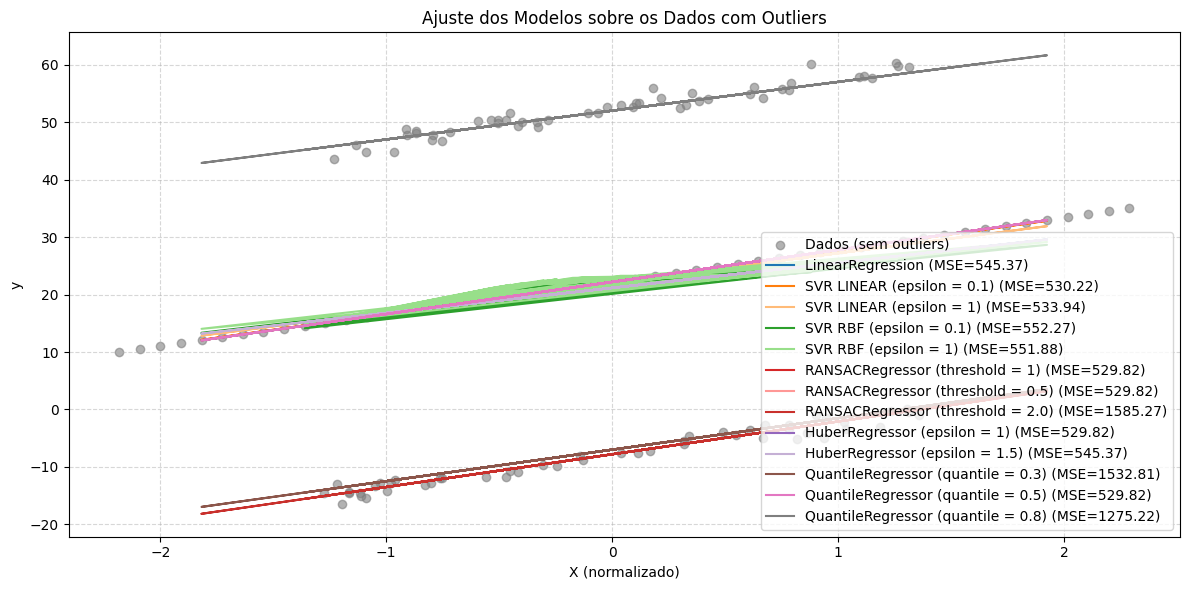

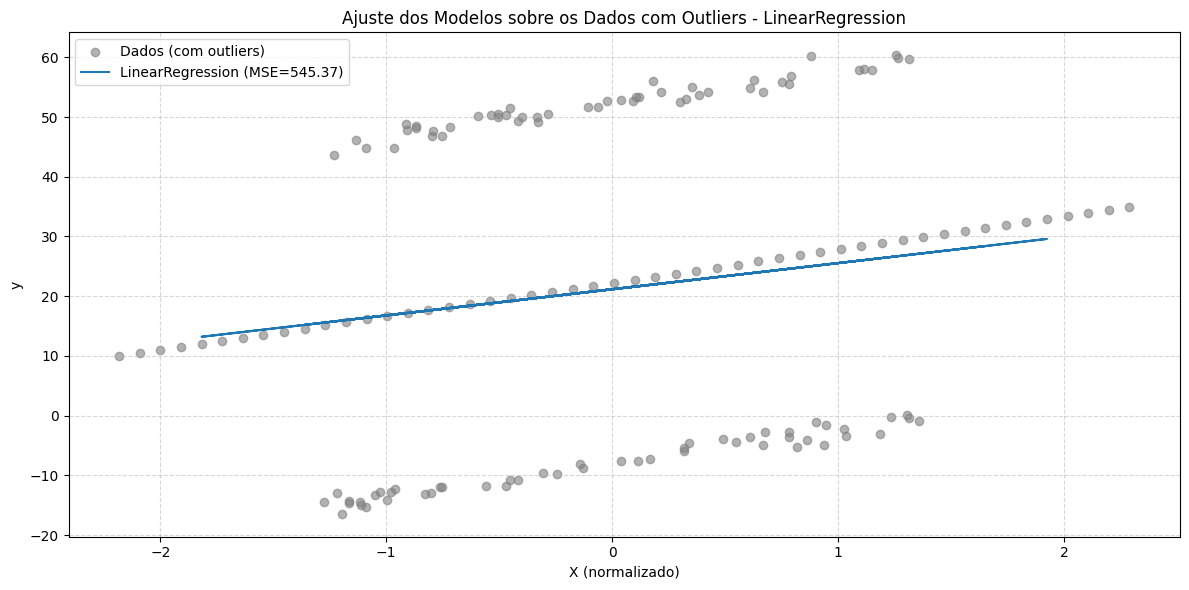

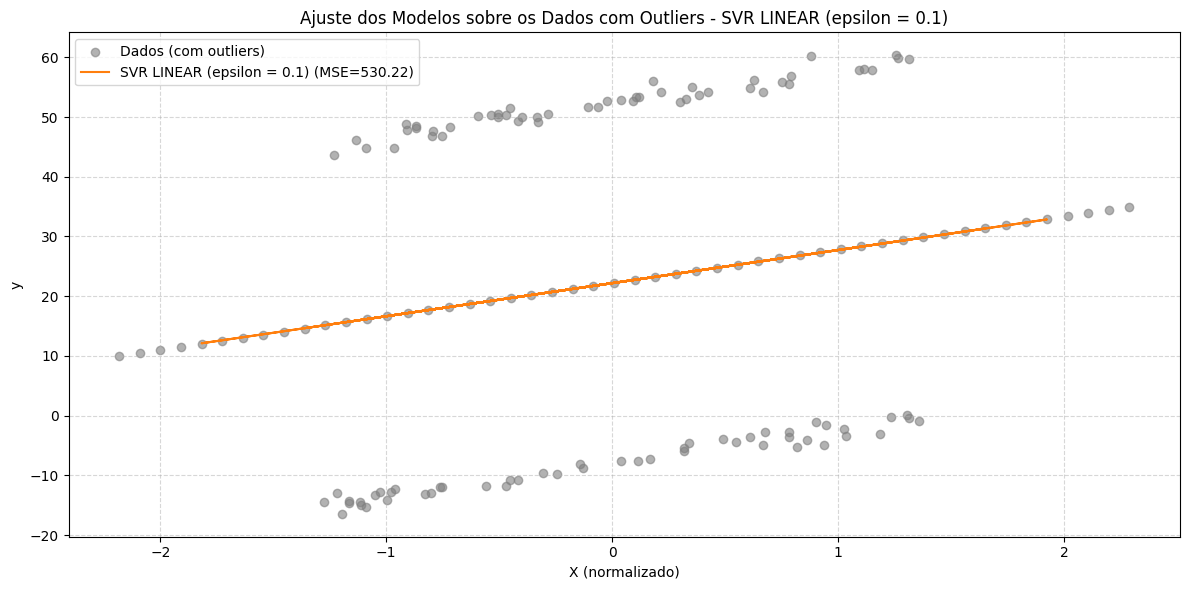

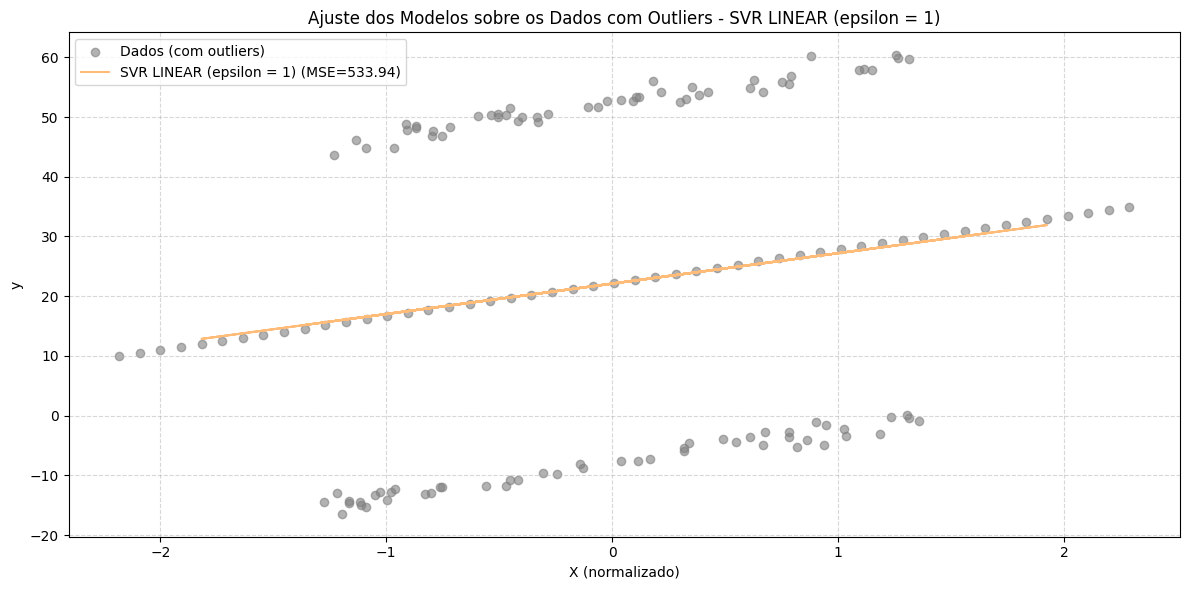

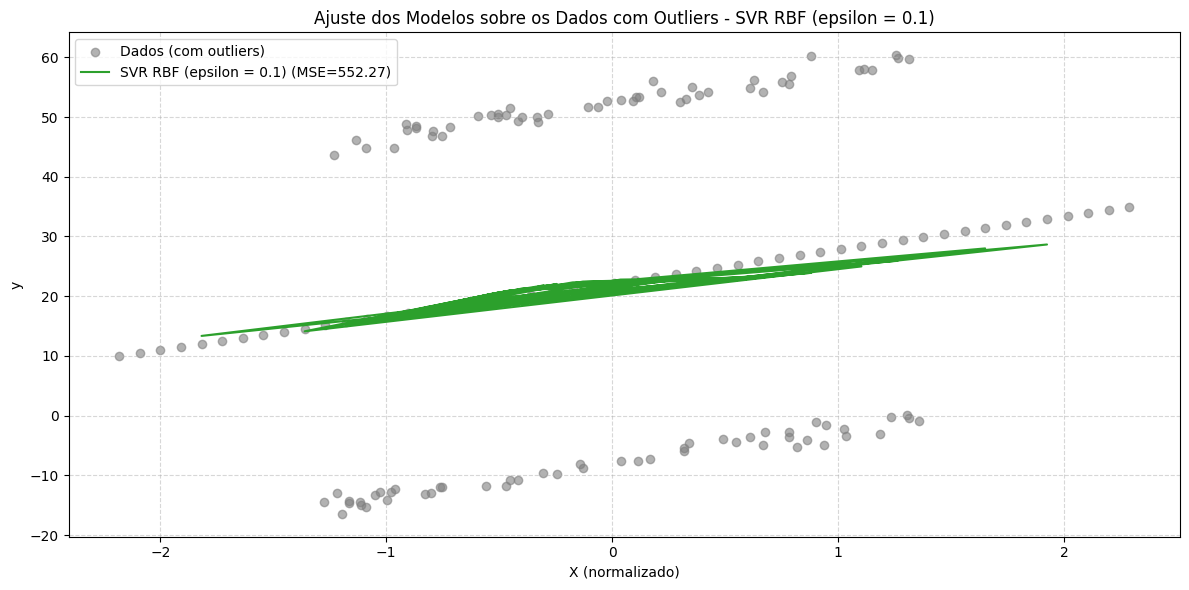

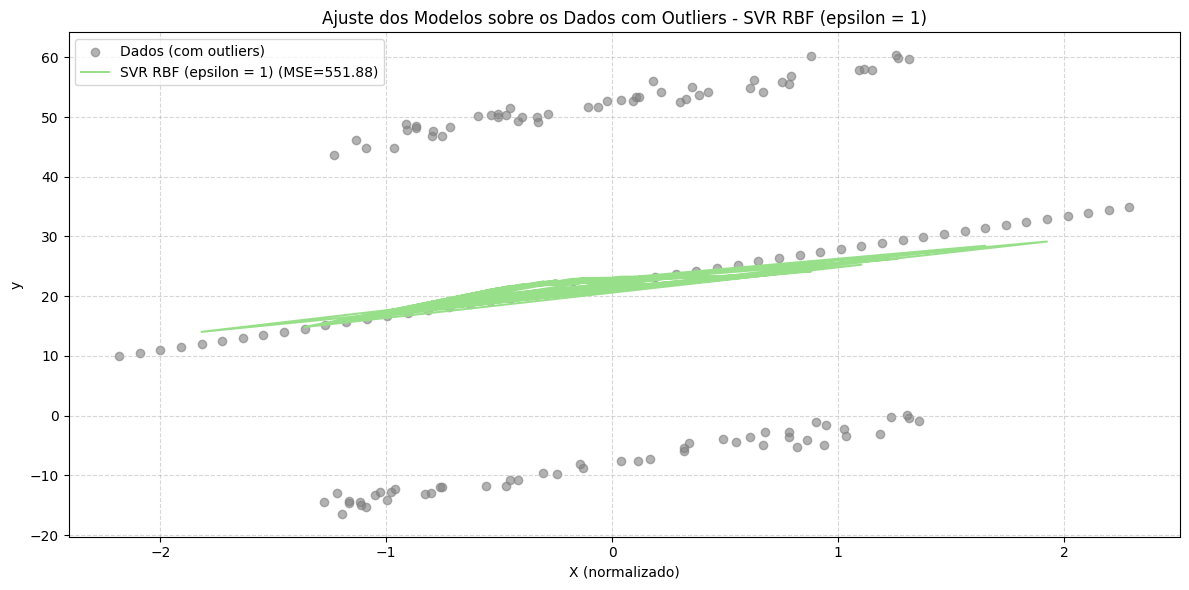

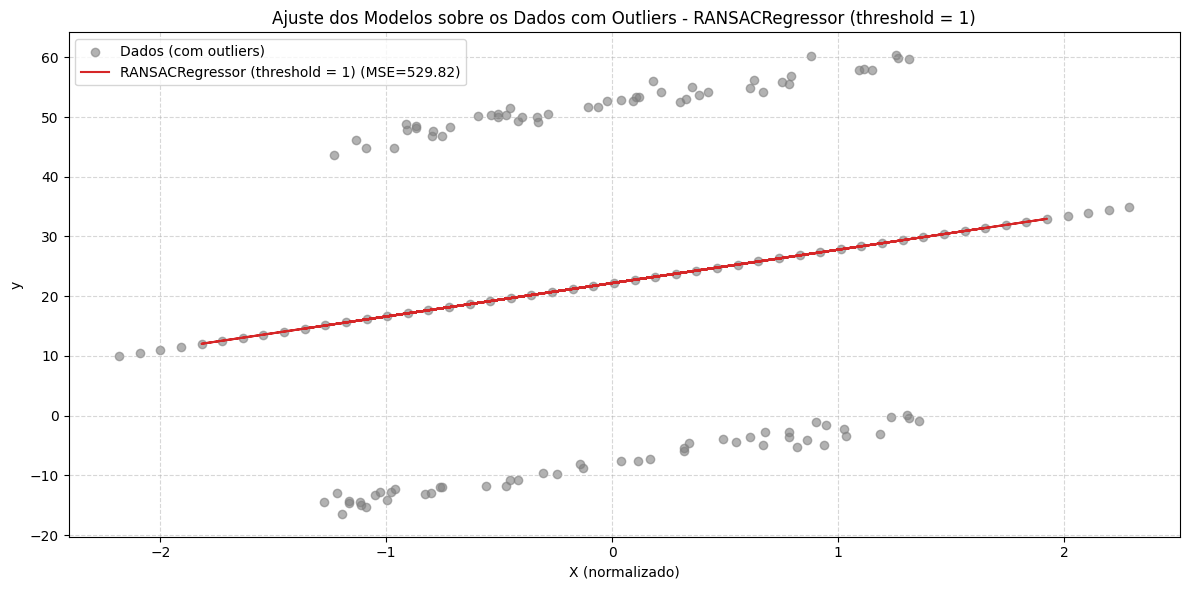

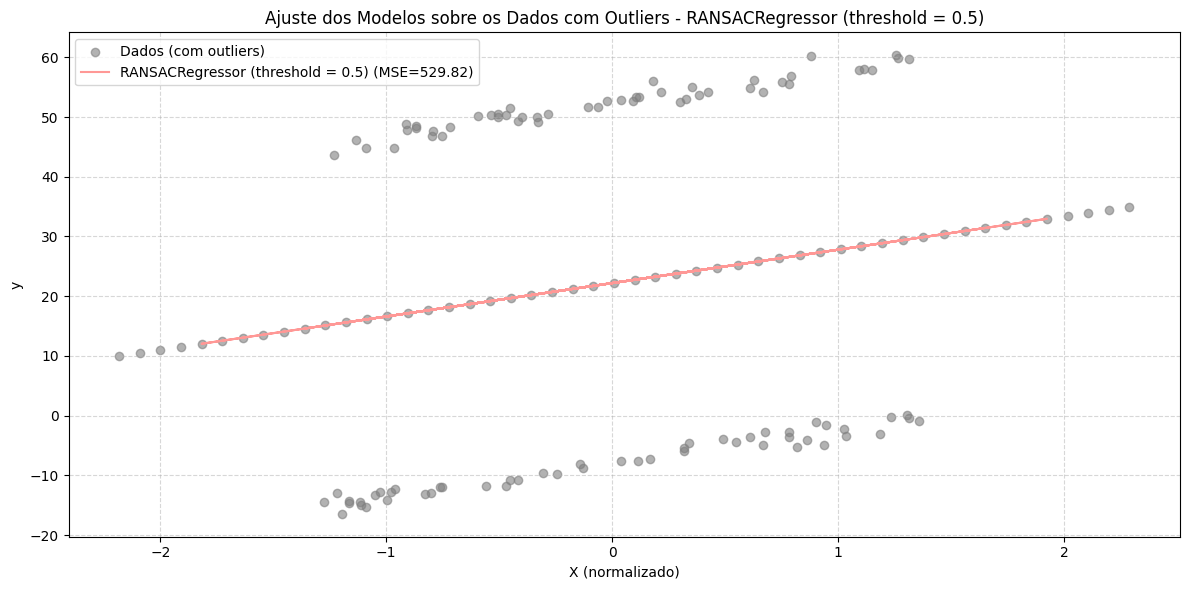

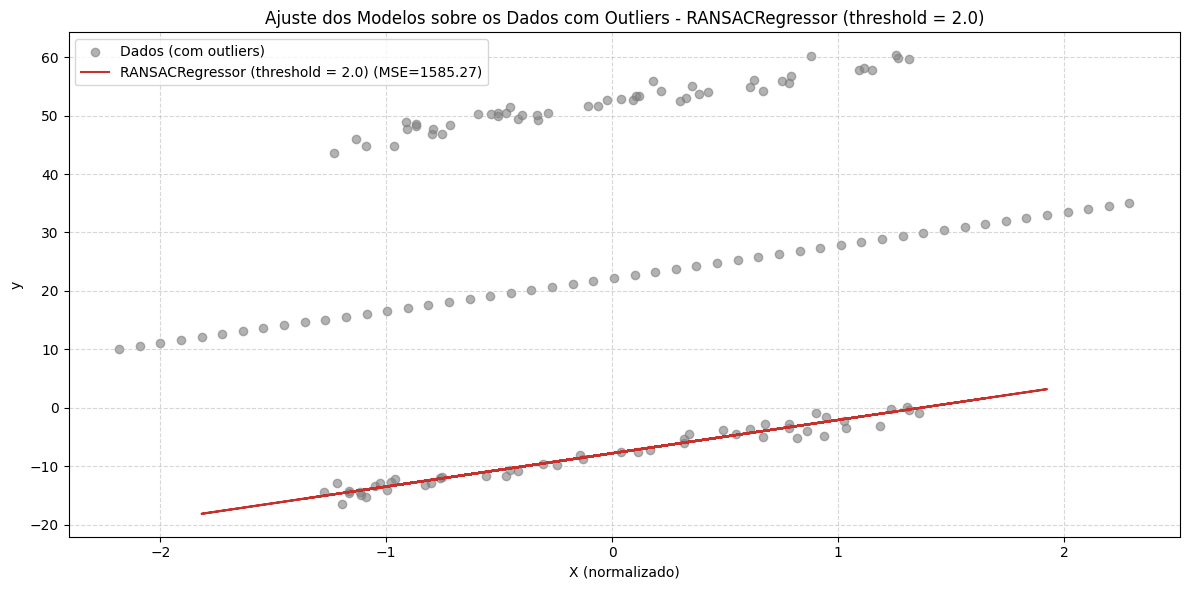

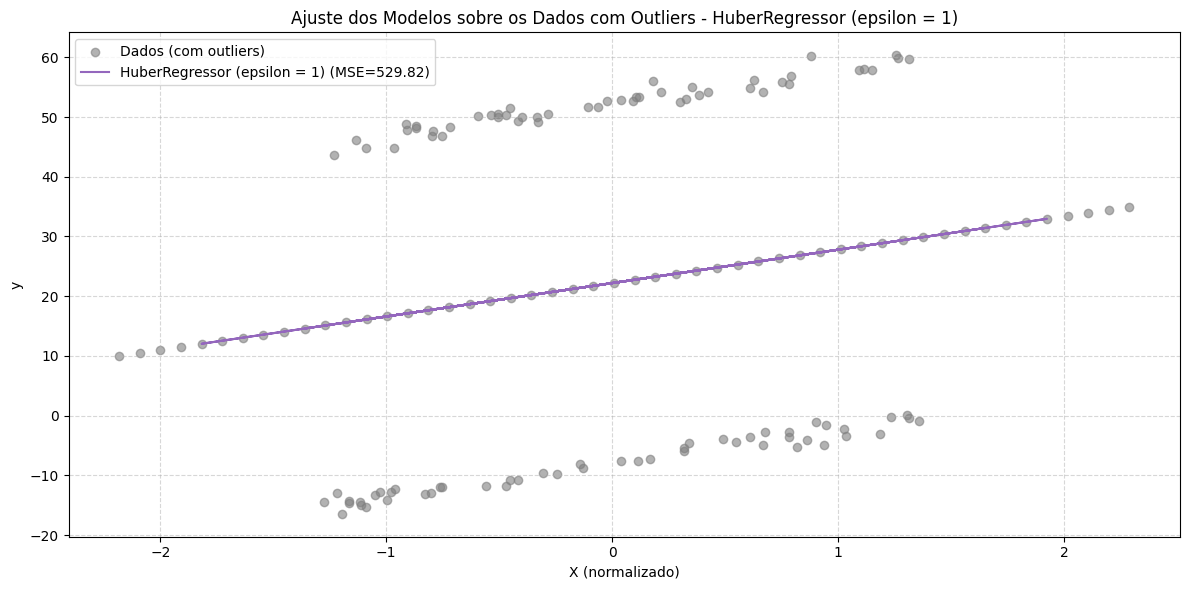

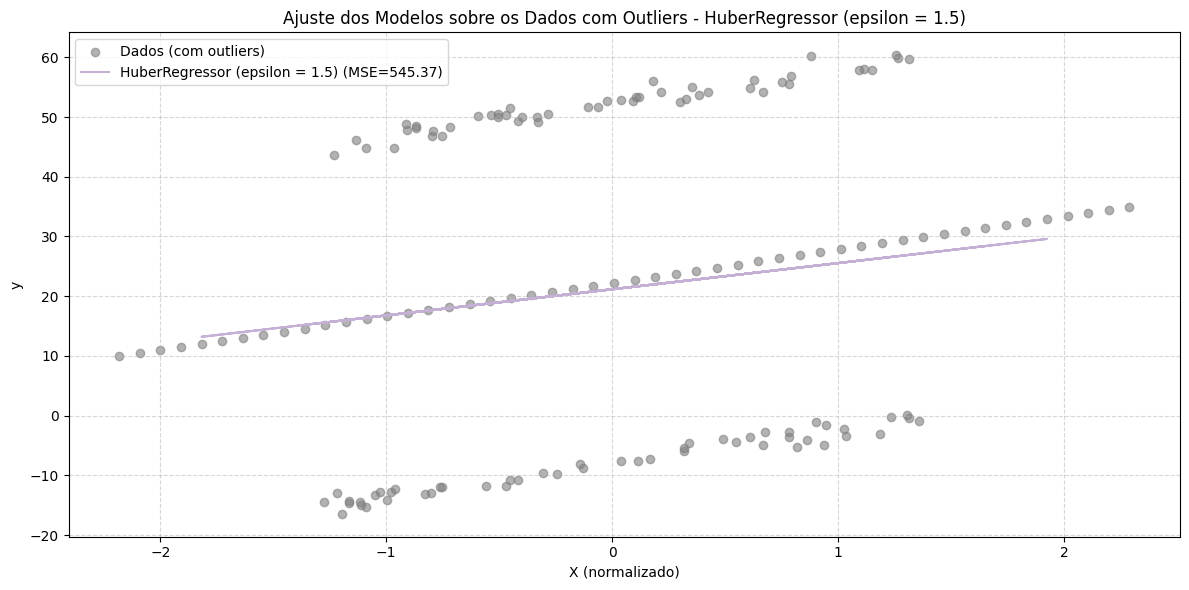

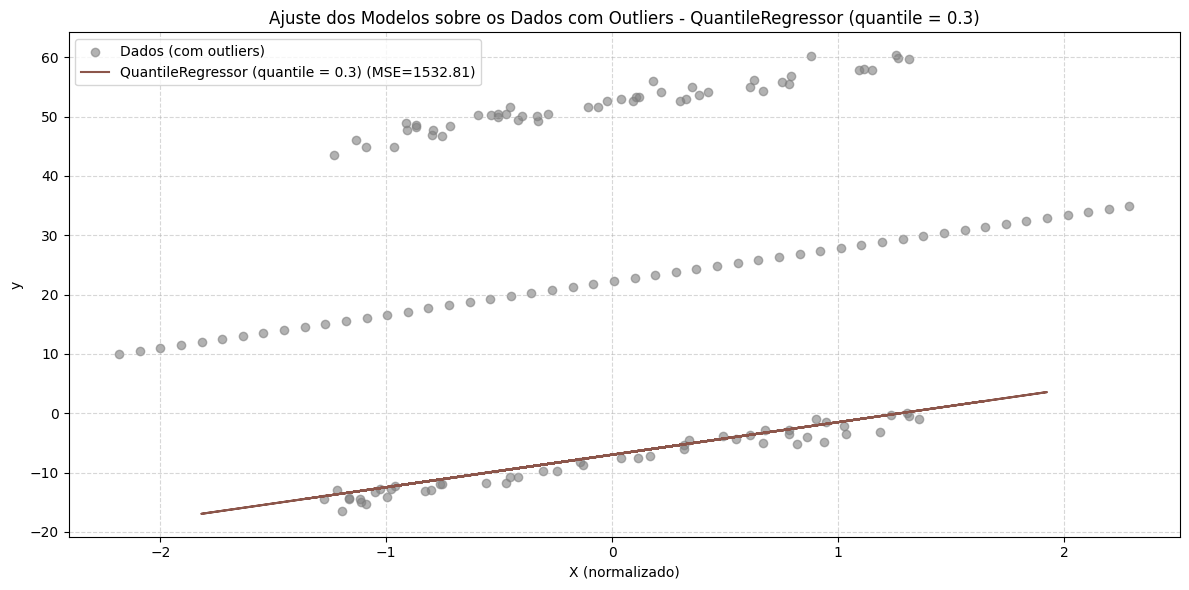

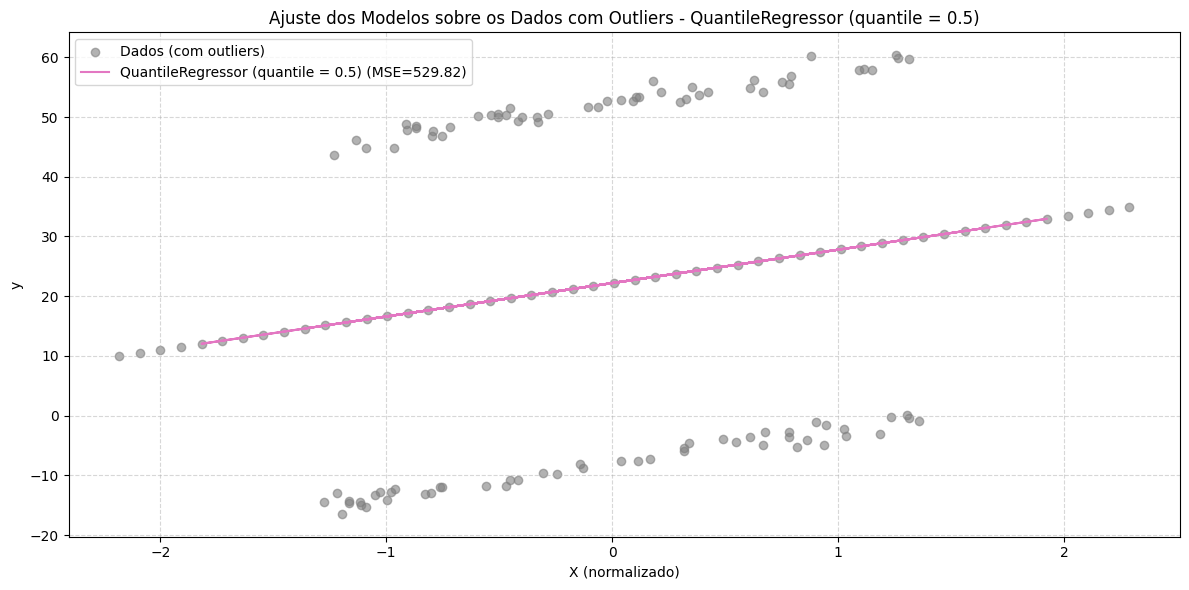

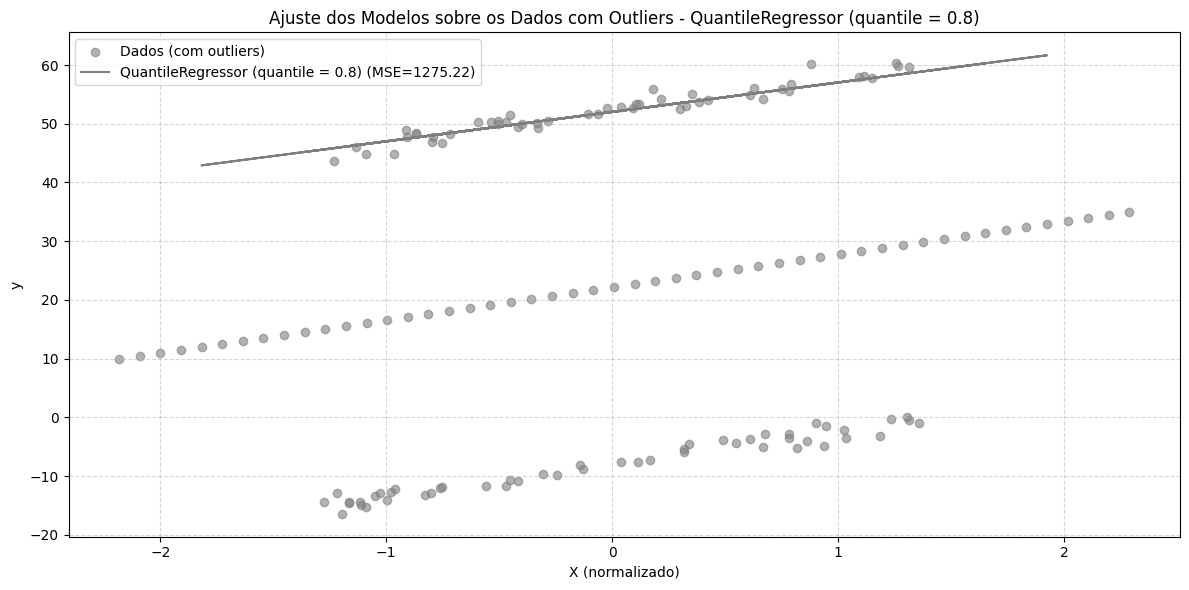

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers.synthetic_data import generate_linear_data
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, QuantileRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



LINEAR         = "LinearRegression"
SVR_LINEAR_0_1 = "SVR LINEAR (epsilon = 0.1)"
SVR_LINEAR_1   = "SVR LINEAR (epsilon = 1)"
SVR_RBF_0_1    = "SVR RBF (epsilon = 0.1)"
SVR_RBF_1      = "SVR RBF (epsilon = 1)"
RANSAC_1       = "RANSACRegressor (threshold = 1)"
RANSAC_0_5     = "RANSACRegressor (threshold = 0.5)"
RANSAC_2_0     = "RANSACRegressor (threshold = 2.0)"
HUBER_1        = "HuberRegressor (epsilon = 1)"
HUBER_1_5      = "HuberRegressor (epsilon = 1.5)"
QUANTILE_0_3   = "QuantileRegressor (quantile = 0.3)"
QUANTILE_0_5   = "QuantileRegressor (quantile = 0.5)"
QUANTILE_0_8   = "QuantileRegressor (quantile = 0.8)"

np.random.seed(43)
n_samples    = 50
n_outliers   = 100
offset       = 30
noise_std    = 1.0
limiar       = 3.0

# Geração dos dados com outliers
X, y = generate_linear_data(
    ang_coef=2.5,
    linear_coef=10.0,
    n_samples=n_samples,
    with_outliers=True,
    n_outliers=n_outliers,
    outlier_offset=offset,
    noise_std=noise_std,
)

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    LINEAR:         LinearRegression(),

    SVR_LINEAR_0_1: SVR(kernel="linear", epsilon=0.1),
    SVR_LINEAR_1:   SVR(kernel="linear", epsilon=1),

    SVR_RBF_0_1:    SVR(kernel="rbf", epsilon=0.1),
    SVR_RBF_1:      SVR(kernel="rbf", epsilon=1),

    RANSAC_1:       RANSACRegressor(estimator=LinearRegression(), residual_threshold=1.0, random_state=42),
    RANSAC_0_5:     RANSACRegressor(estimator=LinearRegression(), residual_threshold=0.5, random_state=42),
    RANSAC_2_0:     RANSACRegressor(estimator=LinearRegression(), residual_threshold=2.0, random_state=42),

    HUBER_1:        HuberRegressor(epsilon=1),
    HUBER_1_5:      HuberRegressor(epsilon=1.5),

    QUANTILE_0_3:   QuantileRegressor(quantile=0.3, alpha=0),
    QUANTILE_0_5:   QuantileRegressor(quantile=0.5, alpha=0),
    QUANTILE_0_8:   QuantileRegressor(quantile=0.8, alpha=0),
}

predictions = dict()
mses = dict()

for algorithm, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[algorithm] = y_pred
    mses[algorithm] = mean_squared_error(y_test, y_pred)

show_mse_per_model(mses)

plt.figure(figsize=(12, 6))
plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (sem outliers)')

model_colors = {
    LINEAR:         "#1f77b4",  # azul

    SVR_LINEAR_0_1: "#ff7f0e",  # laranja
    SVR_LINEAR_1:   "#ffbb78",  # laranja claro

    SVR_RBF_0_1:    "#2ca02c",  # verde
    SVR_RBF_1:      "#98df8a",  # verde claro

    RANSAC_1:       "#d62728",  # vermelho
    RANSAC_0_5:     "#ff9896",  # vermelho claro
    RANSAC_2_0:     "#c9302c",  # vermelho escuro

    HUBER_1:        "#9467bd",  # roxo
    HUBER_1_5:      "#c5b0d5",  # roxo claro

    QUANTILE_0_3:     "#8c564b",  # marrom
    QUANTILE_0_5:     "#e377c2",  # rosa
    QUANTILE_0_8:     "#7f7f7f",  # cinza
}

for algorithm, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=model_colors[algorithm])

plt.title("Ajuste dos Modelos sobre os Dados com Outliers")
plt.xlabel("X (normalizado)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

for algorithm, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=model_colors[algorithm])
    plt.title(f"Ajuste dos Modelos sobre os Dados com Outliers - {algorithm}")
    plt.xlabel("X (normalizado)")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Análise

> Os resultados mostram que quatro modelos apresentaram MSEs praticamente idênticos: RANSACRegressor com thresholds 0.5 e 1, QuantileRegressor com quantil 0.5 e HuberRegressor com epsilon igual a 1. Isso indica que todos conseguiram capturar bem a tendência central dos dados mesmo na presença de outliers. Em seguida, o SVR linear com epsilon 0.1 teve desempenho um pouco inferior, mas ainda competitivo. A regressão linear e o Huber com epsilon 1.5 apresentaram erros maiores, indicando maior sensibilidade a valores extremos. O SVR com kernel RBF teve desempenho mais fraco, e os piores resultados ficaram com os QuantileRegressors dos quantis 0.3 e 0.8 e com o RANSAC com threshold 2.0, sugerindo que valores mais distantes da mediana ou thresholds mais permissivos prejudicam a qualidade do ajuste. O experimento reforça que, além da escolha do modelo, a calibragem dos parâmetros de robustez influencia diretamente o desempenho.

> Comparando este experimento com o Experimento 2, observa-se uma melhora significativa no desempenho do RANSAC ao ajustar seus hiperparâmetros. No experimento anterior, o modelo foi utilizado com as configurações padrão, sem definição explícita de threshold ou de um estimador base, o que resultou no pior desempenho entre todos os modelos avaliados (MSE ≈ 1140). Já no Experimento 5, ao empregar um estimador linear e thresholds ajustados (0.5 e 1.0), o RANSAC apresentou um desempenho muito superior, alcançando o menor MSE entre os modelos comparados. Isso evidencia o impacto direto da escolha adequada dos hiperparâmetros na robustez e eficácia do modelo.